In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load trained model
with open('../models/fraud_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Load metrics
with open('../models/metrics.json', 'r') as f:
    metrics = json.load(f)

# Load feature names
with open('../models/feature_names.json', 'r') as f:
    feature_names = json.load(f)

print("Model loaded successfully!")
print(f"Number of features: {len(feature_names)}")
print(f"\nTest Set Metrics:")
for key, value in metrics['metrics'].items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")

Model loaded successfully!
Number of features: 43

Test Set Metrics:
  threshold: 0.7500
  accuracy: 0.9996
  precision: 0.9915
  recall: 0.9894
  f1: 0.9905
  roc_auc: 0.9999
  average_precision: 0.9970
  specificity: 0.9998


Top 20 Most Important Features:
                      feature  importance
13               amount_small    0.225165
10                 amount_raw    0.120853
33          receiver_tx_count    0.120434
32            is_new_receiver    0.106355
11                 amount_log    0.074229
23         time_since_last_tx    0.060394
30              amount_2x_avg    0.058498
21           tx_amount_1h_log    0.045494
31              amount_3x_avg    0.039625
39  new_receiver_large_amount    0.039295
19               tx_amount_1h    0.026809
17                tx_count_1h    0.009365
22          tx_amount_24h_log    0.006197
4            is_early_morning    0.006176
0                        hour    0.005849
29           amount_deviation    0.004759
5           is_business_hours    0.004477
20              tx_amount_24h    0.004405
28            user_std_amount    0.004253
3                    is_night    0.004033


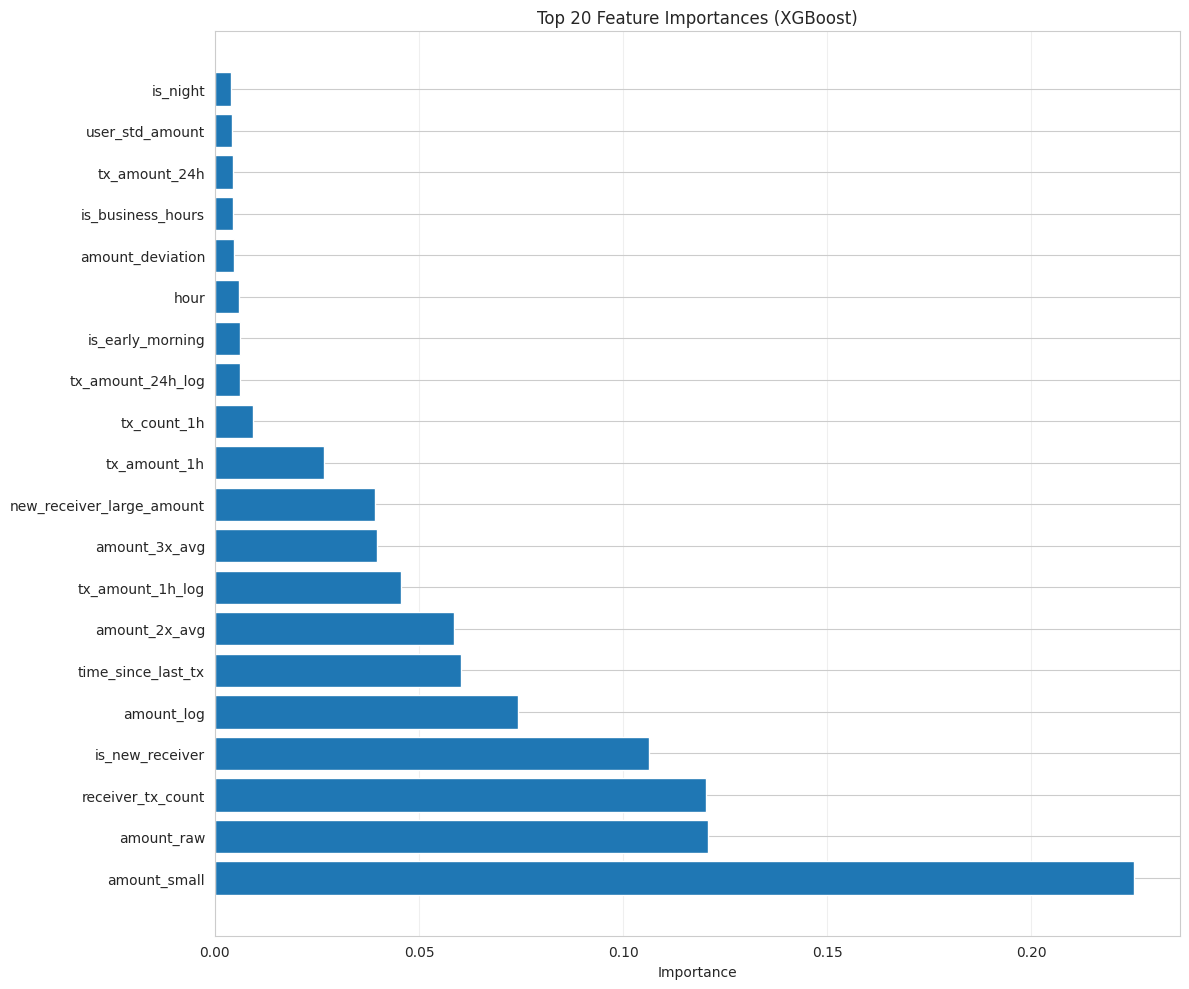

In [2]:
# Feature Importance Analysis
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print("="*60)
print(importance_df.head(20))

# Visualize
plt.figure(figsize=(12, 10))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['importance'].values)
plt.yticks(range(len(top_20)), top_20['feature'].values)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [3]:
# Load test data
df = pd.read_csv('../data/processed/transactions_features.csv')

# Get feature columns
metadata_cols = ['transaction_id', 'user_id', 'timestamp', 'is_fraud']
feature_cols = [col for col in df.columns if col not in metadata_cols]

# Sample some fraud and legitimate transactions
fraud_samples = df[df['is_fraud'] == 1].sample(5, random_state=42)
legit_samples = df[df['is_fraud'] == 0].sample(5, random_state=42)
samples = pd.concat([fraud_samples, legit_samples])

# Make predictions
X_samples = samples[feature_cols]
predictions = model.predict_proba(X_samples)[:, 1]

# Display results
results = pd.DataFrame({
    'transaction_id': samples['transaction_id'].values,
    'actual_fraud': samples['is_fraud'].values,
    'predicted_score': predictions,
    'predicted_fraud': (predictions >= 0.5).astype(int)
})

print("\nSample Predictions:")
print("="*80)
print(results.to_string(index=False))

# Detailed view
print("\n\nDetailed Analysis of Samples:")
print("="*80)
for idx, row in samples.iterrows():
    actual = row['is_fraud']
    pred_score = predictions[list(samples.index).index(idx)]
    
    print(f"\nTransaction: {row['transaction_id']}")
    print(f"  Actual: {'FRAUD' if actual else 'LEGITIMATE'}")
    print(f"  Predicted Score: {pred_score:.4f} ({'FRAUD' if pred_score >= 0.5 else 'LEGITIMATE'})")
    print(f"  Key features:")
    print(f"    - Amount: {row['amount_raw']:.2f} KES")
    print(f"    - Amount deviation: {row['amount_deviation']:.2f}")
    print(f"    - Hour: {row['hour']} ({'Night' if row['is_night'] else 'Day'})")
    print(f"    - Tx count (1h): {row['tx_count_1h']}")
    print(f"    - Device changed: {row['device_changed_flag']}")
    print(f"    - New receiver: {row['is_new_receiver']}")
    print("-"*80)


Sample Predictions:
                      transaction_id  actual_fraud  predicted_score  predicted_fraud
ce5a7113-2753-45b2-84fa-1ca04cc32237          True         0.999906                1
7ea562a1-6284-4253-82f0-bfcf5c1ff235          True         0.999924                1
71e3e120-29ee-4488-b5ef-2d6d0eaaf20d          True         0.999918                1
3b901f2a-e7ef-4d95-a02b-bb0249bb6438          True         0.999509                1
0c04e31e-0e01-44a6-b20a-ccded5abd95d          True         0.999875                1
26107e84-0a4f-4f89-9052-7fca7c4229e7         False         0.000083                0
8b5e3471-8a96-4c4d-9a8a-18bd5a9f94dc         False         0.000048                0
2b2ce9f6-de1a-4d32-8f2f-a351557e2ca6         False         0.000073                0
7904710c-fb94-41db-bb6f-8945144cd23d         False         0.000165                0
917176e9-a081-453a-ad44-35dceb3ffae6         False         0.000124                0


Detailed Analysis of Samples:

Transaction

In [4]:
# Confusion Matrix Analysis
cm = np.array(metrics['confusion_matrix'])
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix Breakdown:")
print("="*80)
print(f"True Negatives (TN):  {tn:,}  - Correctly identified legitimate")
print(f"False Positives (FP): {fp:,}  - Legitimate flagged as fraud (False Alarm)")
print(f"False Negatives (FN): {fn:,}  - Fraud missed (Most Costly!)")
print(f"True Positives (TP):  {tp:,}  - Correctly caught fraud")

print(f"\nKey Metrics:")
print(f"  Fraud Detection Rate (Recall): {tp/(tp+fn):.1%}")
print(f"  False Alarm Rate: {fp/(fp+tn):.2%}")
print(f"  When flagged as fraud, correct: {tp/(tp+fp):.1%} (Precision)")

# Cost analysis (example)
print(f"\nCost Analysis (Example):")
avg_fraud_amount = 8500  # KES, from data
false_alarm_cost = 50    # KES, customer service time

cost_of_missed_fraud = fn * avg_fraud_amount
cost_of_false_alarms = fp * false_alarm_cost
total_cost = cost_of_missed_fraud + cost_of_false_alarms

print(f"  Cost of missed fraud (FN): {cost_of_missed_fraud:,.0f} KES")
print(f"  Cost of false alarms (FP): {cost_of_false_alarms:,.0f} KES")
print(f"  Total cost: {total_cost:,.0f} KES")


Confusion Matrix Breakdown:
True Negatives (TN):  19,628  - Correctly identified legitimate
False Positives (FP): 4  - Legitimate flagged as fraud (False Alarm)
False Negatives (FN): 5  - Fraud missed (Most Costly!)
True Positives (TP):  467  - Correctly caught fraud

Key Metrics:
  Fraud Detection Rate (Recall): 98.9%
  False Alarm Rate: 0.02%
  When flagged as fraud, correct: 99.2% (Precision)

Cost Analysis (Example):
  Cost of missed fraud (FN): 42,500 KES
  Cost of false alarms (FP): 200 KES
  Total cost: 42,700 KES


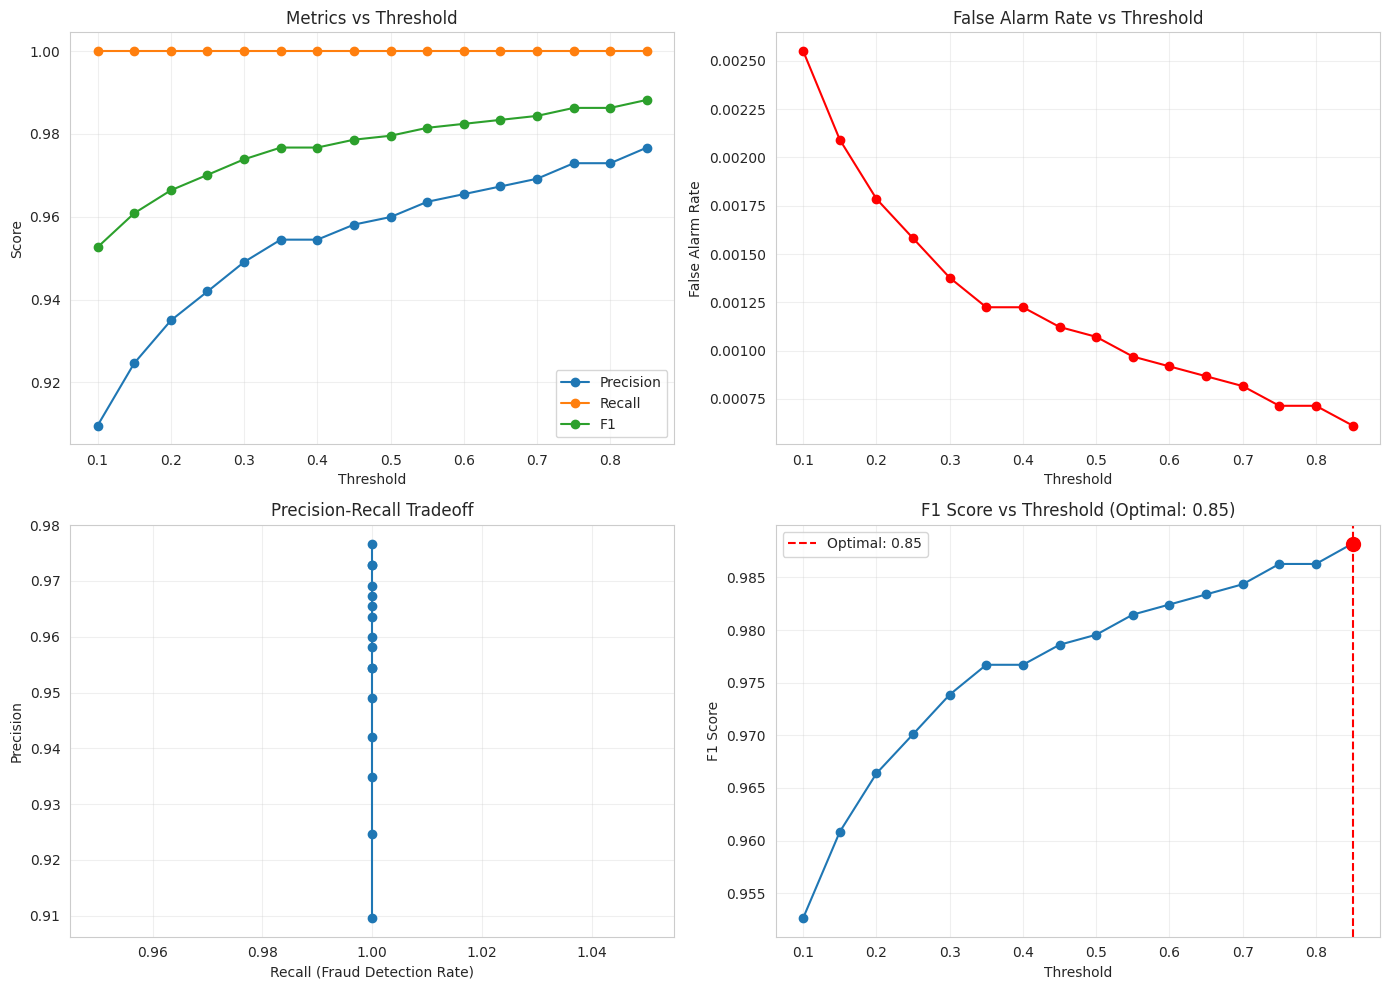


Optimal Threshold Analysis:
threshold           0.850000
precision           0.976699
recall              1.000000
f1                  0.988212
false_alarm_rate    0.000612
Name: 15, dtype: float64


In [5]:
# Threshold Analysis
X = df[feature_cols]
y = df['is_fraud']
_, X_test, _, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics at different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
results_by_threshold = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # False alarm rate
    tn = ((y_pred == 0) & (y_test == 0)).sum()
    fp = ((y_pred == 1) & (y_test == 0)).sum()
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    results_by_threshold.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'false_alarm_rate': false_alarm_rate
    })

threshold_df = pd.DataFrame(results_by_threshold)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Precision, Recall, F1
axes[0, 0].plot(threshold_df['threshold'], threshold_df['precision'], label='Precision', marker='o')
axes[0, 0].plot(threshold_df['threshold'], threshold_df['recall'], label='Recall', marker='o')
axes[0, 0].plot(threshold_df['threshold'], threshold_df['f1'], label='F1', marker='o')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Metrics vs Threshold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# False Alarm Rate
axes[0, 1].plot(threshold_df['threshold'], threshold_df['false_alarm_rate'], 
                marker='o', color='red')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('False Alarm Rate')
axes[0, 1].set_title('False Alarm Rate vs Threshold')
axes[0, 1].grid(True, alpha=0.3)

# Precision-Recall tradeoff
axes[1, 0].plot(threshold_df['recall'], threshold_df['precision'], marker='o')
axes[1, 0].set_xlabel('Recall (Fraud Detection Rate)')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Tradeoff')
axes[1, 0].grid(True, alpha=0.3)

# F1 vs Threshold (highlight optimal)
optimal_idx = threshold_df['f1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
optimal_f1 = threshold_df.loc[optimal_idx, 'f1']

axes[1, 1].plot(threshold_df['threshold'], threshold_df['f1'], marker='o')
axes[1, 1].axvline(x=optimal_threshold, color='r', linestyle='--', 
                    label=f'Optimal: {optimal_threshold:.2f}')
axes[1, 1].scatter([optimal_threshold], [optimal_f1], color='red', s=100, zorder=5)
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title(f'F1 Score vs Threshold (Optimal: {optimal_threshold:.2f})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nOptimal Threshold Analysis:")
print("="*80)
print(threshold_df.loc[optimal_idx])

In [6]:
# Compare Different Balance Strategies
print("\nComparing Balance Strategies:")
print("="*80)
print("\nWe trained with 'class_weight' strategy.")
print("Let's see how other strategies would perform...")
print("\n(This is illustrative - actual training would take time)")

strategies_comparison = {
    'class_weight': {
        'description': 'Use XGBoost scale_pos_weight parameter',
        'pros': ['Fast', 'No data augmentation', 'Works well for tree models'],
        'cons': ['May not work for highly imbalanced data'],
        'our_results': metrics['metrics']
    },
    'smote': {
        'description': 'Synthetic Minority Over-sampling Technique',
        'pros': ['Creates synthetic fraud samples', 'Increases fraud examples'],
        'cons': ['Slower training', 'Risk of overfitting', 'Synthetic data may not be realistic'],
        'typical_results': 'Higher recall, possibly lower precision'
    },
    'undersample': {
        'description': 'Randomly remove majority class samples',
        'pros': ['Balanced dataset', 'Faster training'],
        'cons': ['Loses legitimate transaction data', 'May hurt generalization'],
        'typical_results': 'Balanced, but may sacrifice overall accuracy'
    }
}

for strategy, info in strategies_comparison.items():
    print(f"\n{strategy.upper()}:")
    print(f"  Description: {info['description']}")
    print(f"  Pros: {', '.join(info['pros'])}")
    print(f"  Cons: {', '.join(info['cons'])}")
    if 'our_results' in info:
        print(f"  Our Results:")
        print(f"    - Precision: {info['our_results']['precision']:.4f}")
        print(f"    - Recall: {info['our_results']['recall']:.4f}")
        print(f"    - F1: {info['our_results']['f1']:.4f}")
    else:
        print(f"  Expected: {info['typical_results']}")


Comparing Balance Strategies:

We trained with 'class_weight' strategy.
Let's see how other strategies would perform...

(This is illustrative - actual training would take time)

CLASS_WEIGHT:
  Description: Use XGBoost scale_pos_weight parameter
  Pros: Fast, No data augmentation, Works well for tree models
  Cons: May not work for highly imbalanced data
  Our Results:
    - Precision: 0.9915
    - Recall: 0.9894
    - F1: 0.9905

SMOTE:
  Description: Synthetic Minority Over-sampling Technique
  Pros: Creates synthetic fraud samples, Increases fraud examples
  Cons: Slower training, Risk of overfitting, Synthetic data may not be realistic
  Expected: Higher recall, possibly lower precision

UNDERSAMPLE:
  Description: Randomly remove majority class samples
  Pros: Balanced dataset, Faster training
  Cons: Loses legitimate transaction data, May hurt generalization
  Expected: Balanced, but may sacrifice overall accuracy



Feature Importance by Category:
                 total_importance
Amount                   0.427318
Receiver                 0.226789
Velocity                 0.156844
User History             0.115616
Interaction              0.039741
Time                     0.028558
Device/Location          0.005135


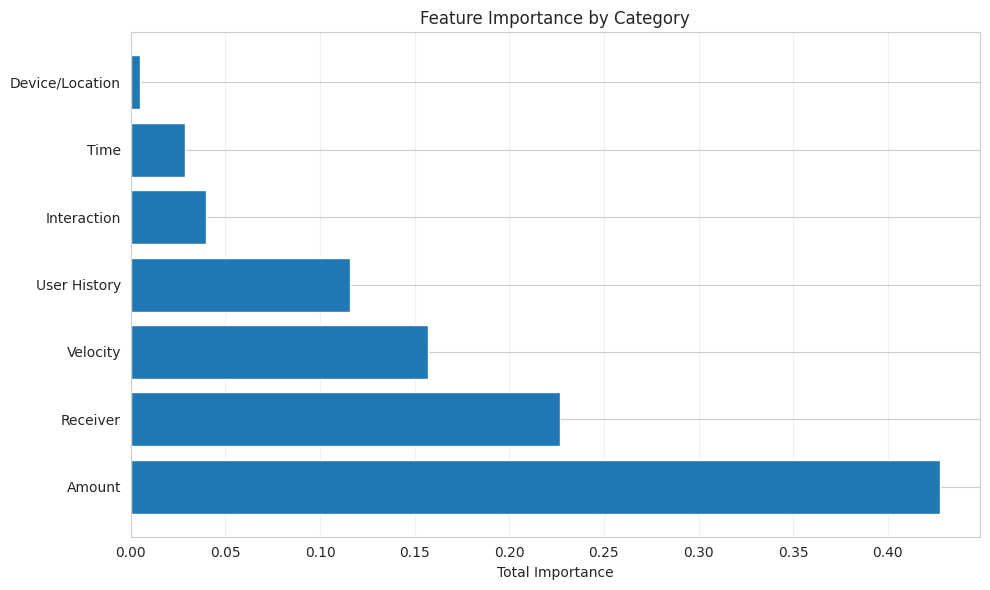


Key Insights:
1. Most important category: Amount
2. Top 3 categories account for: 81.1% of importance
3. This tells us fraud is primarily detected through: Amount, Receiver, Velocity


In [7]:
# Model Interpretability: Top Features by Category
feature_categories = {
    'Time': ['hour', 'day_of_week', 'is_weekend', 'is_night', 'is_early_morning', 
             'is_business_hours', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos'],
    'Amount': ['amount_raw', 'amount_log', 'amount_very_small', 'amount_small', 
               'amount_medium', 'amount_large', 'amount_very_large'],
    'Velocity': ['tx_count_1h', 'tx_count_24h', 'tx_amount_1h', 'tx_amount_24h',
                 'tx_amount_1h_log', 'tx_amount_24h_log', 'time_since_last_tx', 
                 'avg_tx_amount_24h'],
    'User History': ['user_tx_number', 'user_total_amount', 'user_avg_amount', 
                     'user_std_amount', 'amount_deviation', 'amount_2x_avg', 'amount_3x_avg'],
    'Receiver': ['is_new_receiver', 'receiver_tx_count'],
    'Device/Location': ['device_changed_flag', 'location_changed_flag', 
                        'device_or_location_changed', 'device_and_location_changed'],
    'Interaction': ['high_amount_at_night', 'new_receiver_large_amount',
                    'device_changed_unusual_amount', 'high_velocity_large_amount',
                    'night_device_change']
}

# Calculate importance by category
category_importance = {}
for category, features in feature_categories.items():
    category_features = [f for f in features if f in importance_df['feature'].values]
    total_importance = importance_df[
        importance_df['feature'].isin(category_features)
    ]['importance'].sum()
    category_importance[category] = total_importance

# Sort and display
category_df = pd.DataFrame.from_dict(
    category_importance, orient='index', columns=['total_importance']
).sort_values('total_importance', ascending=False)

print("\nFeature Importance by Category:")
print("="*80)
print(category_df)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(range(len(category_df)), category_df['total_importance'].values)
plt.yticks(range(len(category_df)), category_df.index)
plt.xlabel('Total Importance')
plt.title('Feature Importance by Category')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../docs/importance_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey Insights:")
print("="*80)
print(f"1. Most important category: {category_df.index[0]}")
print(f"2. Top 3 categories account for: {category_df.head(3)['total_importance'].sum():.1%} of importance")
print(f"3. This tells us fraud is primarily detected through: {', '.join(category_df.head(3).index)}")